In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
from scipy.stats import beta
import plotly.express as px
from datetime import datetime
from dotenv import load_dotenv
from snowflake import connector

import warnings
# Filter out all warnings
warnings.filterwarnings('ignore', category=Warning)

from leading_indicator_v2 import *

In [2]:
load_dotenv('/Users/peter/.env')

# establish Snowflake connection
connection = connector.connect(user=os.getenv("SNOWFLAKE_USERNAME"), 
                  password=os.getenv("SNOWFLAKE_PASSWORD"), 
                  account=os.getenv("SNOWFLAKE_ACCOUNT"), 
                  role=os.getenv("SNOWFLAKE_ROLE"), 
                  warehouse=os.getenv("SNOWFLAKE_WAREHOUSE"),
                  database = 'DISCO_CORE' 
                  )

## Prepare Data

In [30]:
def run_queries(connection, start_date = '2024-04-01'):
    
    #SQL Queries:
    raw_daily_display_query = f"""
    select 
        to_date(event_created_at) as event_date,
        -- widget_type,
        -- ml_model,
        case 
            when widget_type = 'DISCOFEED' and ml_model not ilike '%waterfall%' and e.ml_model != 'contextual' then 'bert_boost_classic'
            when ml_model ilike '%waterfall%' then 'waterfall'
            when widget_type = 'LEAD_GEN' then 'nurture'
            when ml_model = 'contextual' and widget_type != 'LEAD_GEN' then 'contextual_classic'
            else 'other' 
        end as load_type,
        count(distinct event_id) as brand_displays
    from event.event e 
    where
        event_name = 'widget_brand_display'
        and to_date(event_created_at) between '{start_date}' and current_date -1
        -- and ml_model is null
        and brand_name != publisher_name
    group by all 
    order by event_date asc
    """

    raw_daily_display_click_query = f"""
    with displays as (
    select 
        to_date(event_created_at) as event_date,
        -- widget_type,
        -- ml_model,
        case 
            when widget_type = 'DISCOFEED' and ml_model not ilike '%waterfall%' and e.ml_model != 'contextual' then 'bert_boost_classic'
            when ml_model ilike '%waterfall%' then 'waterfall'
            when widget_type = 'LEAD_GEN' then 'nurture'
            when ml_model = 'contextual' and widget_type != 'LEAD_GEN' then 'contextual_classic'
            else 'other' 
        end as load_type,
        count(distinct event_id) as brand_displays
    from event.event e 
    where
        event_name = 'widget_brand_display'
        and to_date(event_created_at) between '{start_date}' and current_date -1
        -- and ml_model is null
        and brand_name != publisher_name
    group by all),
    clicks as (
    select 
        to_date(event_created_at) as event_date,
        -- widget_type,
        -- ml_model,
        case 
            when widget_type = 'DISCOFEED' and ml_model not ilike '%waterfall%' and e.ml_model != 'contextual' then 'bert_boost_classic'
            when ml_model ilike '%waterfall%' then 'waterfall'
            when widget_type = 'LEAD_GEN' then 'nurture'
            when ml_model = 'contextual' and widget_type != 'LEAD_GEN' then 'contextual_classic'
            else 'other' 
        end as load_type,
        count(distinct event_id) as clicks
    from event.event e 
    where
        event_name in ('widget_brand_click', 'widget_product_click')
        and to_date(event_created_at) between '{start_date}' and current_date -1
        -- and ml_model is null
        and brand_name != publisher_name
    group by all 
    )
    select 
        event_date,
        load_type,
        brand_displays,
        case when clicks is null then 0 else clicks end as clicks
    from displays d 
    left join clicks c using (event_date, load_type)
    order by event_date asc
    ;
    """

    raw_zero_day_adspend_query = f"""
    select 
        to_date(event_created_at) as event_date,
        case 
            when e.widget_type = 'DISCOFEED' and e.ml_model not ilike '%waterfall%' and e.ml_model != 'contextual' then 'bert_boost_classic'
            when e.ml_model ilike '%waterfall%' then 'waterfall'
            when e.widget_type = 'LEAD_GEN' then 'nurture'
            when e.ml_model = 'contextual' and e.widget_type != 'LEAD_GEN' then 'contextual_classic'
            else 'other' 
        end as load_type,
        sum(case when billable_amount is null then 0 else billable_amount end) as zeroday_ad_spend
    from curated.ad_spend_revenue asr 
    left join event.event e using (event_id)
    where 
        conversion_type = 'cross-sell'
        and to_date(event_created_at) between '{start_date}' and current_date -1
        and days_to_attribution = 0
    group by all 
    order by event_date asc
    ;
    """

    final_conv_query = f"""
    select 
        to_date(c.event_created_at) as event_date,
        count(distinct c.order_id) as final_conv_count,
        sum(case when billable_amount is null then 0 else billable_amount end) as final_ad_spend,
    from curated.ad_spend_revenue c
    where 
        c.conversion_type = 'cross-sell'
        and to_date(c.event_created_at) between '{start_date}' and current_date -1
        -- and c.days_to_attribution = 0
    group by all 
    order by event_date asc
    ;
    """

    daily_order_query = f"""
    select 
        to_date(created_at_gmt) as event_date,
        count(distinct order_id) as order_count
    from orders.order_data_flattened
    where 
        to_date(created_at_gmt) between '{start_date}' and current_date-1
    group by all
    order by event_date asc
    ;
    """

    annual_seasonality_query = f"""
    with loads as (
    select 
        date,
        sum(publisher_widget_loads) as loads
    from curated.combined_discofeed_daily
    where 
        date between '2023-01-01' and '2023-12-31'
    group by all),
    revenue as (
    select 
        to_date(conversion_order_time) as date,
        count(distinct conversion_unique_key) as conv_count,
        sum(bod_spend) as ad_spend,
    from curated.legacy_ad_spend_revenue
    where 
        date between '2023-01-01' and '2023-12-31'
    group by all 
    ),
    daily as (
    select 
        *,
        conv_count / loads as cvr,
        ad_spend / loads as rpl
    from loads 
    join revenue using (date)
    order by date asc),
    averages as (
    select 
        avg(loads) as avg_loads,
        avg(conv_count) as avg_conv,
        avg(ad_spend) as avg_adspend,
        avg(cvr) as avg_cvr,
        avg(rpl) as avg_rpl,
    from daily 
    )
    select 
        date as event_date, 
        loads / (select avg_loads from averages) as loads_index,
        conv_count / (select avg_conv from averages) as conv_index,
        ad_spend / (select avg_adspend from averages) as adspend_index,
        cvr / (select avg_cvr from averages) as cvr_index,
        rpl / (select avg_rpl from averages) as rpl_index,
    from daily
    ;
    """
    #Run Queries
    raw_daily_display = pd.read_sql(raw_daily_display_query, connection)
    raw_daily_display_click = pd.read_sql(raw_daily_display_click_query, connection)
    raw_zero_day_adspend = pd.read_sql(raw_zero_day_adspend_query, connection)
    final_conv = pd.read_sql(final_conv_query, connection)
    daily_order = pd.read_sql(daily_order_query, connection)
    annual_seasonality = pd.read_sql(annual_seasonality_query, connection)

    return raw_daily_display, raw_daily_display_click, raw_zero_day_adspend, final_conv, daily_order, annual_seasonality

def pivot_data(df, value, index = 'event_date', column = 'load_type'):
    #lowercase the columns
    df.columns = df.columns.str.lower()
    #Pivot the data by load type
    pivot = df.pivot(index=index, columns=column, values=value).reset_index()
    #fill NaN values with 0
    pivot = pivot.fillna(0)
    #remove the index name
    pivot.columns.name = None
    #add a subscript of "_displays" to all of the columns except 'event_data' 
    pivot.columns = ['event_date'] + [col + '_' + value for col in pivot.columns[1:]]
    return pivot
    
def merge_data(raw_daily_display, raw_daily_display_click, raw_zero_day_adspend, final_conv, daily_order, annual_seasonality):
    #Pivot the raw daily data
    display_pivot = pivot_data(raw_daily_display, 'brand_displays')
    zero_day_adspend_pivot = pivot_data(raw_zero_day_adspend, 'zeroday_ad_spend')

    #Merge the two pivoted datasets
    merged_df = pd.merge(display_pivot, zero_day_adspend_pivot, on='event_date')
    
    #Lowercase the columns for the daily order, final conversion, and annual seasonality data
    daily_order.columns = daily_order.columns.str.lower()
    final_conv.columns = final_conv.columns.str.lower()
    annual_seasonality.columns = annual_seasonality.columns.str.lower()

    #merge the daily order data
    merged_df = pd.merge(merged_df, daily_order, on='event_date')
    #merge the final conversion data
    merged_df = pd.merge(merged_df, final_conv, on='event_date')
    #calculate rpl as final_ad_spend divided by the sum of all the display columns
    merged_df['rpl'] = round(merged_df['final_ad_spend'] / merged_df.iloc[:, 1:5].sum(axis=1),3)
    #convert the event_date column to datetime
    merged_df['event_date'] = pd.to_datetime(merged_df['event_date'])
    #Add a day of week column
    merged_df['day_of_week'] = merged_df['event_date'].dt.dayofweek
    #Add a day of month column
    merged_df['day_of_month'] = merged_df['event_date'].dt.day
    #Add a day count column that counts the number of days since the start of the dataset
    merged_df['day_count'] = range(1, len(merged_df)+1)

    #Add Seasonality via inner join of annual seasonality's date column
    annual_seasonality = annual_seasonality[['event_date', 'rpl_index']]
    #convert the event_date column to datetime for annual seasonality
    annual_seasonality['event_date'] = pd.to_datetime(annual_seasonality['event_date'])
    #Add one year to the annual seasonality date column
    annual_seasonality['event_date'] = annual_seasonality['event_date'] + pd.DateOffset(years=1)
    merged_df = pd.merge(merged_df, annual_seasonality, on='event_date', how='left')
    return merged_df

def ingest_clean_data(connection, start_date = '2024-04-01'):
    #Print a status message
    print(f'Ingesting performance data from {start_date}')
    raw_daily_display, raw_daily_display_click, raw_zero_day_adspend, final_conv, daily_order, annual_seasonality = run_queries(connection)
    print('Data successfully ingested.')
    merged_df = merge_data(raw_daily_display, raw_daily_display_click, raw_zero_day_adspend, final_conv, daily_order, annual_seasonality)
    return merged_df

In [31]:
df = ingest_clean_data(connection)
df.sample(5)

Ingesting performance data from 2024-04-01
Data successfully ingested.


,event_date,bert_boost_classic_brand_displays,contextual_classic_brand_displays,nurture_brand_displays,other_brand_displays,waterfall_brand_displays,bert_boost_classic_zeroday_ad_spend,contextual_classic_zeroday_ad_spend,nurture_zeroday_ad_spend,other_zeroday_ad_spend,waterfall_zeroday_ad_spend,order_count,final_conv_count,final_ad_spend,rpl,day_of_week,day_of_month,day_count,rpl_index
27,2024-04-28,179819.0,61125.0,2.0,6627.0,59587.0,1480.00,335.0,0.0,75.0,387.98,183310,745,10342.74,0.042,6,28,28,0.883519
18,2024-04-19,279808.0,14244.0,24650.0,14765.0,20781.0,1124.50,0.0,38.0,100.0,80.00,189823,759,9222.44,0.028,4,19,19,1.130277
49,2024-05-20,212674.0,17922.0,14911.0,17688.0,97849.0,1552.39,15.0,85.0,55.0,325.00,194697,883,11164.00,0.042,0,20,50,1.128245
42,2024-05-13,231143.0,20623.0,18663.0,16345.0,98422.0,1837.00,109.0,166.0,215.0,496.00,188917,1050,14527.66,0.051,0,13,43,1.018339
29,2024-04-30,202596.0,62280.0,7.0,12545.0,115693.0,1207.94,123.0,0.0,86.0,219.00,191573,983,11879.58,0.043,1,30,30,1.008519


## Modeling

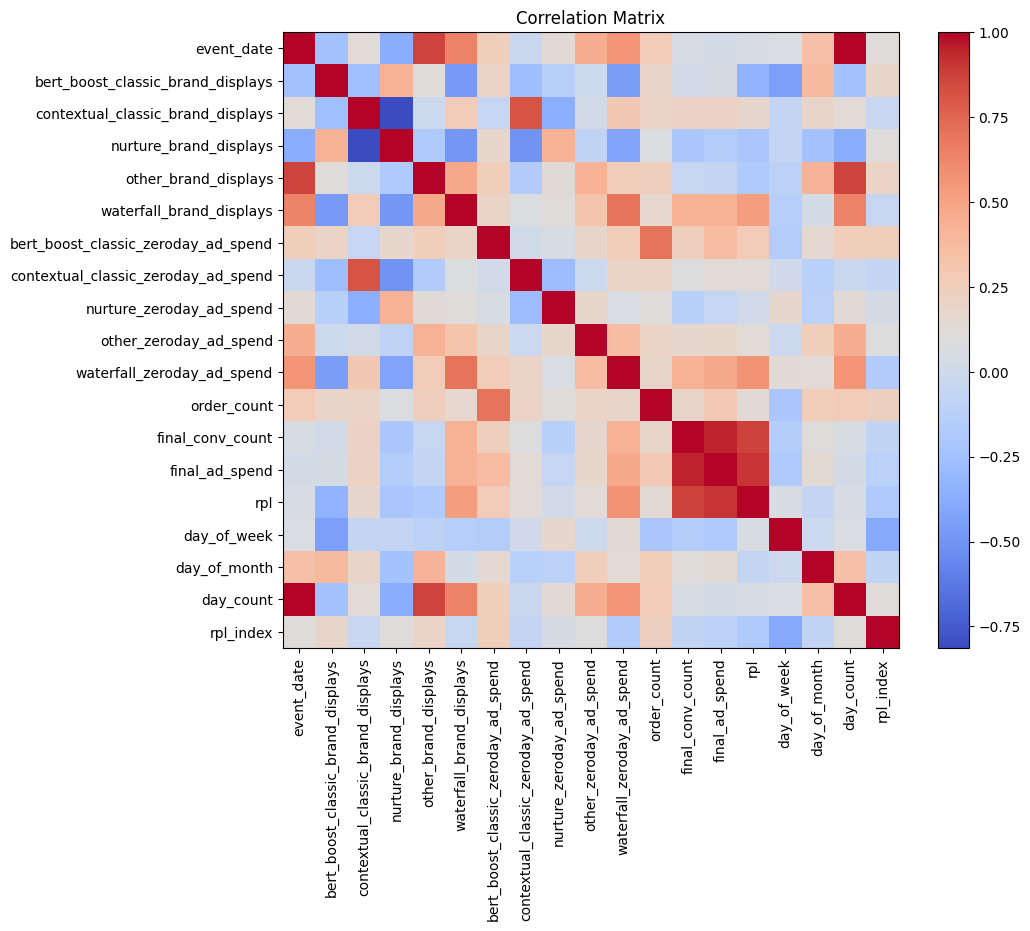

In [32]:
from numpy import asarray
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.metrics import mean_squared_error, r2_score, make_scorer
from sklearn.model_selection import train_test_split, GridSearchCV, KFold
from sklearn.ensemble import RandomForestRegressor
import xgboost as xgb
from functools import partial

#Generate Correlation Matrix
corr_matrix = df.corr()

# Plot correlation matrix
plt.figure(figsize=(10,8))
plt.title("Correlation Matrix")
plt.imshow(corr_matrix, cmap="coolwarm", interpolation="nearest")
plt.colorbar()
plt.xticks(range(len(corr_matrix.columns)), corr_matrix.columns, rotation=90)
plt.yticks(range(len(corr_matrix.columns)), corr_matrix.columns)
plt.show()

In [24]:
def scale_and_split_data(df):
    scaler = StandardScaler()
    #copy the merged_df dataframe
    scaled_df = df.copy()

    #isolate the features as all columns except 'event_date', 'rpl', 'conversion_rate', 'final_conv_count', 'final_ad_spend' 
    X = scaled_df.drop(columns=['event_date', 'rpl', 'final_conv_count', 'final_ad_spend'])
    Y = df[['rpl', 'final_ad_spend']]

    # #scale the input data
    X_scaled = scaler.fit_transform(X)
    #Append the scaled data to the scaled_df dataframe
    scaled_df[X.columns] = X_scaled
    return scaled_df, X, Y

In [55]:
x_scaled, X, Y = scale_and_split_data(df)
x_scaled.sample(5)

,event_date,bert_boost_classic_brand_displays,contextual_classic_brand_displays,nurture_brand_displays,other_brand_displays,waterfall_brand_displays,bert_boost_classic_zeroday_ad_spend,contextual_classic_zeroday_ad_spend,nurture_zeroday_ad_spend,other_zeroday_ad_spend,waterfall_zeroday_ad_spend,order_count,final_conv_count,final_ad_spend,rpl,day_of_week,day_of_month,day_count,rpl_index
45,2024-05-16,-0.134695,-0.175791,-0.228510,0.793033,0.808042,0.360434,-0.583278,-0.943384,-0.987670,-0.006873,-0.456037,967,12843.12,0.048,0.023218,0.098108,0.730798,-1.264750
22,2024-04-23,0.598539,-0.585052,0.382024,-0.612064,-1.102904,-0.393823,-0.048494,-0.784144,-0.069972,-0.928453,-0.460021,675,9536.83,0.034,-0.967424,0.869204,-0.514265,0.073630
54,2024-05-25,-0.409847,-0.143329,-0.158119,0.723164,0.479928,2.062536,0.033780,1.077743,0.213680,0.338301,1.431678,713,10912.80,0.042,1.013860,1.089517,1.217997,-0.944302
25,2024-04-26,0.446634,0.454984,-0.131958,-0.205985,0.059142,-0.142035,0.691975,-0.024690,1.548514,0.224360,0.113581,917,11724.97,0.040,0.518539,1.199674,-0.351866,-0.671077
28,2024-04-29,0.076067,2.528525,-2.747106,-0.714295,0.663597,-0.757629,0.157192,-1.457852,-0.069972,0.291384,0.839035,957,12016.84,0.041,-1.462745,1.530143,-0.189466,-0.286574


### Approach 1: Take most recent days as training

In [73]:
def optimize_random_forest_hyperparameters(X_train, y_train):

    # Define the model
    rf = RandomForestRegressor(random_state=42)

    # Define the parameter grid
    param_grid = {
        'n_estimators': [50, 100, 200],
        'max_depth': [3, 5, 10, None],
        'min_samples_split': [2, 5, 10],
        'min_samples_leaf': [1, 2, 4],
        'max_features': ['auto', 'sqrt', 'log2']
    }

    # Define the scorer
    scorer = make_scorer(mean_squared_error, greater_is_better=False)

    # Setup the grid search
    grid_search = GridSearchCV(estimator=rf,
                            param_grid=param_grid,
                            scoring=scorer,
                            cv=5,  # 5-fold cross-validation
                            n_jobs=-1,  # Use all available cores
                            verbose=1)

    # Fit grid search to the train set
    grid_search.fit(X_train, y_train)

    # Get the best parameters and model
    best_params = grid_search.best_params_
    best_model = grid_search.best_estimator_

    print("Best parameters:", best_params)
    return best_model

def remove_last_n_days(X,y, n):
     #Cut off the last 14 days of data
    current_date = datetime.today().date()
    #set cutoff date to 14 days before the current date
    cutoff_date = pd.Timestamp(current_date - pd.Timedelta(days=n))
    #filter out all rows where the event_date is greater than the cutoff date
    unattributed_X = X[X['event_date'] >= cutoff_date]
    unattributed_Y = y.tail(14)
    X_final = X[x_scaled['event_date'] < cutoff_date]
    X_final = X.drop(columns=['event_date'])
    y_final = y.drop(y.tail(14).index)                      

    return X_final, y_final, unattributed_X, unattributed_Y

def train_test_split_latest_data(X, y, training_size=0.2):
    #Determine the nearest integer to % of the dataset to use for training
    train_size = round(len(X) * training_size)
    #Set training data 
    X_train = X[:train_size]
    y_train = y[:train_size]
    #Set test data
    X_test = X[train_size:]
    y_test = y[train_size:]

    return X_train, X_test, y_train, y_test
    

In [65]:
def find_model_performance(x_scaled, target, objective = 'rpl', training_size = 0.7):
    X = x_scaled.sort_values('event_date').copy()
    y = target[objective].copy()
    
    X, y, unattributed_X, unattributed_Y = remove_last_n_days(X,y, 14)
    
    #Determine the nearest integer to % of the dataset to use for training
    train_size = round(len(X) * training_size)
    #Set training data 
    X_train = X[:train_size]
    y_train = y[:train_size]
    #Set test data
    X_test = X[train_size:]
    y_test = y[train_size:]

    # Fit the Linear Regression model
    linear_reg = LinearRegression()
    linear_reg.fit(X_train, y_train)
    y_pred_lr = linear_reg.predict(X_test)
    y_train_pred_lr = linear_reg.predict(X_train)  # Predictions on the training set

    # Calculate Errors on test and train data for Linear Regression
    lr_rmse_test = mean_squared_error(y_test, y_pred_lr, squared=False)
    lr_rmse_train = mean_squared_error(y_train, y_train_pred_lr, squared=False)
    mean_abs_error_pct_lr_test = round((abs(y_test - y_pred_lr) / y_test).mean(),3)
    mean_abs_error_pct_lr_train = round((abs(y_train - y_train_pred_lr) / y_train).mean(),3)

    #Optimize the Random Forest model and predict on the test data
    best_rf_model = optimize_random_forest_hyperparameters(X_train, y_train)
    y_pred_rf = best_rf_model.predict(X_test)
    y_train_pred_rf = best_rf_model.predict(X_train)  # Predictions on the training set

    # Calculate Errors on test and train data for Random Forest
    rf_rmse_test = mean_squared_error(y_test, y_pred_rf, squared=False)
    rf_rmse_train = mean_squared_error(y_train, y_train_pred_rf, squared=False)
    mean_abs_error_pct_rf_test = round((abs(y_test - y_pred_rf) / y_test).mean(),3)
    mean_abs_error_pct_rf_train = round((abs(y_train - y_train_pred_rf) / y_train).mean(),3)

    # Save the results to a dataframe with additional columns for training errors
    results = pd.DataFrame({
        'model': ['Linear Regression', 'Random Forest'],
        'RMSE Test': [lr_rmse_test, rf_rmse_test],
        'RMSE Train': [lr_rmse_train, rf_rmse_train],
        'Mean Abs Error % Test': [mean_abs_error_pct_lr_test, mean_abs_error_pct_rf_test],
        'Mean Abs Error % Train': [mean_abs_error_pct_lr_train, mean_abs_error_pct_rf_train]
    })

    #Plot a scatter plot of the actual vs predicted values for both models with different colors for each model and a y=x line
    plt.figure(figsize=(8,3))
    plt.scatter(y_test, y_pred_lr, color='blue', label='Linear Regression')
    plt.scatter(y_test, y_pred_rf, color='red', label='Random Forest')
    #Insert label based on the objective variable
    plt.xlabel(f'Actual {objective}')
    plt.ylabel(f'Predicted {objective}')
    plt.title(f'Actual vs Predicted {objective} by Model Type')
    plt.legend()    
    plt.plot([0, 1], [0, 1], transform=plt.gca().transAxes, color='black')
    plt.show()

    return results, linear_reg, best_rf_model, unattributed_X, unattributed_Y

Fitting 5 folds for each of 324 candidates, totalling 1620 fits
Best parameters: {'max_depth': 5, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}


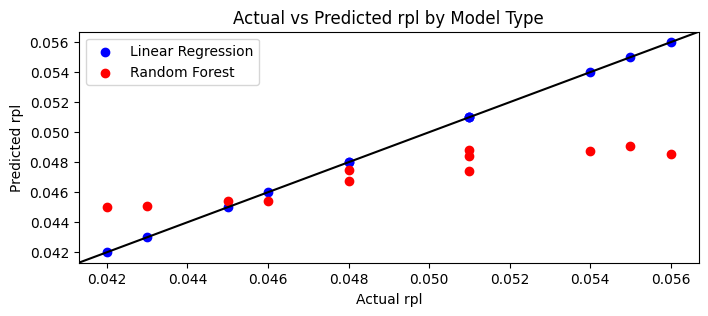

,model,RMSE Test,RMSE Train,Mean Abs Error % Test,Mean Abs Error % Train
0,Linear Regression,1.163860e-16,8.665031e-17,0.000,0.000
1,Random Forest,3.629666e-03,1.018864e-03,0.057,0.022


In [71]:
results, linear_reg, best_rf_model, unattributed_X, unattributed_Y = find_model_performance(x_scaled, Y, objective = 'rpl', training_size= 0.75)
results

In [62]:
#Print the shapes 
print(f'X_train shape: {X_train.shape}')
print(f'y_train shape: {y_train.shape}')
print(f'X_test shape: {X_test.shape}')
print(f'y_test shape: {y_test.shape}')
print(f'y_pred_lr shape: {y_pred_lr.shape}')
print(f'y_train_pred_lr shape: {y_train_pred_lr.shape}')

X_train shape: (35, 18)
y_train shape: (35,)
X_test shape: (15, 18)
y_test shape: (15,)
y_pred_lr shape: (15,)
y_train_pred_lr shape: (35,)


Fitting 5 folds for each of 324 candidates, totalling 1620 fits
Best parameters: {'max_depth': 10, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}


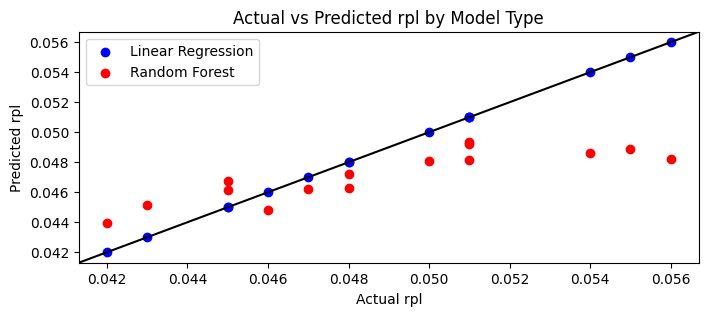

,model,RMSE Test,RMSE Train,Mean Abs Error % Test,Mean Abs Error % Train
0,Linear Regression,1.087488e-15,3.346471e-16,0.000,0.00
1,Random Forest,3.307543e-03,1.030436e-03,0.051,0.02


In [57]:
results, linear_reg, best_rf_model, unattributed_X, unattributed_Y = find_model_performance(x_scaled, Y)
results